In [200]:
import pandas as pd
import pickle
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import extract_time, scores, scores_vis
import importlib
importlib.reload(scores_vis)
importlib.reload(extract_time)
importlib.reload(scores)

<module 'scores' from '/Users/ellie/Documents/Projects/user_scores/scores.py'>

In [86]:
date.today().isoformat()

'2022-04-06'

In [87]:
priority_list = pd.read_csv('/Users/ellie/Documents/Projects/Models_Data/RawData/default_transaction_priority.csv')
label = list(priority_list.label)
pri_class = list(priority_list['class'])

priority_dict = dict(list(zip(label,pri_class)))

In [88]:

with open('/Users/ellie/Documents/Projects/Models_Data/RawData/OBdata/test_df_05042022.pkl','rb') as f:
    pickle.load(f)

In [89]:
df['need_want'] = df.transaction_class.map(priority_dict)

In [165]:
df.head()

,description,timestamp,currency,type,amount,id,merchant,category,runningBalance.currency,runningBalance.amount,description_anon,transaction_class,need_want
0,SAVE THE CHANGE,2021-12-12,GBP,DEBIT,-0.41,4b6afa19a1407cb1321979f8e52ea3dd,,BILL_PAYMENT,GBP,376.03,SAVE THE CHANGE,Savings&Investments,Future You
1,AA MEMBERSHIP,2021-12-12,GBP,DEBIT,-23.11,a5d504ed5625f1009030b39c4afefe54,Aa Membership,DIRECT_DEBIT,GBP,352.92,AA MEMBERSHIP,VehicleCosts,Want
2,PAYPAL BETFRED,2021-12-14,GBP,DEBIT,-2.00,1e9ec87d4fda1a44b787520ed36d8761,Betfred,PURCHASE,GBP,353.44,PAYPAL BETFRED,Gambling,Want
3,MT SECURETRADE LIM,2021-12-14,GBP,CREDIT,43.50,d1df8880ea19fa38dd1fd3a4f5983c2c,,PURCHASE,GBP,376.44,MT SECURETRADE LIM,Savings&Investments,Future You
4,MT SECURETRADE LIM,2021-12-14,GBP,DEBIT,-20.50,83007ff0097149d10aa3b320cc356549,,PURCHASE,GBP,332.94,MT SECURETRADE LIM,Savings&Investments,Future You


In [166]:
scores.budgeting_score(df)
# scores_vis.budget_pie(df)
#scores_vis.spend_bar(df)

90

In [92]:
oldest_transaction = extract_time.BuildDFTime(df)['oldest transaction']
recent_transaction = extract_time.BuildDFTime(df)['recent transaction']

In [66]:
pd.to_datetime(oldest_transaction)[0]

Timestamp('2021-12-12 00:00:00')

In [93]:
timescale='W'

scores_time = pd.DataFrame(columns=['per_start','per_end','score'])
starts=[]

start = pd.to_datetime(oldest_transaction)[0]
end = pd.to_datetime(recent_transaction)[0]
week_starts = list(pd.date_range(start,end,freq=timescale))
for start in week_starts:
    starts.append(start)

scores_time['per_start']=starts
scores_time['per_end']=pd.to_datetime(scores_time.per_start+timedelta(days=6))

start = pd.to_datetime(scores_time.iloc[0]['per_start'])
end =  pd.to_datetime(scores_time.iloc[0]['per_end'])

In [161]:
scores.budgeting_score(df_week)

91

In [156]:
def weekly_score(df):
    b_score=[]   
    df = df.copy()
    for i in scores_time.index:
        start = pd.Timestamp(scores_time.iloc[i]['per_start'])
        end =  pd.Timestamp(scores_time.iloc[i]['per_end'])
        df_week = df[(df.timestamp.dt.date>=start)&(df.timestamp.dt.date<end)]
        score = scores.budgeting_score(df_week)
        b_score.append(score)
    #print(b_score)
    scores_time['score']=b_score
    scores_time['rolling_average']=scores_time.score.rolling(4).mean().fillna(scores_time.score.mean())   
    

    print(f'Budgeting score: {round(sum(b_score)/len(b_score))}')

    return scores_time

In [163]:
weekly_score(df)

Budgeting score: 85


/opt/anaconda3/envs/chat_env/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/chat_env/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,per_start,per_end,score,rolling_average
0,2021-12-12,2021-12-18,80,84.615385
1,2021-12-19,2021-12-25,80,84.615385
2,2021-12-26,2022-01-01,83,84.615385
3,2022-01-02,2022-01-08,90,83.250000
4,2022-01-09,2022-01-15,90,85.750000
5,2022-01-16,2022-01-22,88,87.750000
6,2022-01-23,2022-01-29,82,87.500000
7,2022-01-30,2022-02-05,86,86.500000
8,2022-02-06,2022-02-12,91,86.750000
9,2022-02-13,2022-02-19,74,83.250000


In [160]:
def weekly_b_score(df):    
    # set figure size
    plt.figure( figsize = ( 12, 5))

    df = df.copy()
    
    # plot a simple time series plot
    # using seaborn.lineplot()
    sns.lineplot( x = 'per_end',
                y = 'score',
                data = df,
                color='hotpink',
                label = 'Weekly Score')
    
    # # plot using rolling average
    pal = sns.dark_palette('purple',2)
    sns.lineplot( x = 'per_end',
                y = 'rolling_average',
                data = scores_time,
                color='aquamarine',
                label = 'Rollingavg')
    
    plt.xlabel('Weeks using Good With app')
    
    # setting customized ticklabels for x axis
    pos = [ '2021-12-18', '2021-12-25', '2022-01-01','2022-01-08','2022-01-15','2022-01-22',
    '2022-01-29','2022-02-05','2022-02-12','2022-02-19','2022-02-26','2022-03-05','2022-03-12']

    
    lab = pd.Series(pos).index
    
    plt.xticks( pos, lab)
    
    plt.ylabel('Budgeting Score')

In [116]:
pos = [ '2021-12-18', '2021-12-25', '2022-01-01','2022-01-08','2022-01-15','2022-01-22',
'2022-01-29','2022-02-05','2022-02-12','2022-02-19','2022-02-26','2022-03-05','2022-03-12']

In [177]:
df.columns

Index(['description', 'timestamp', 'currency', 'type', 'amount', 'id',
       'merchant', 'category', 'runningBalance.currency',
       'runningBalance.amount', 'description_anon', 'transaction_class',
       'need_want'],
      dtype='object')

In [189]:
scores.weekly_score(df)

Budgeting score: 25


/opt/anaconda3/envs/chat_env/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/chat_env/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,per_start,per_end,score,rolling_average
0,2021-12-12,2021-12-18,80,84.615385
1,2021-12-19,2021-12-25,80,84.615385
2,2021-12-26,2022-01-01,83,84.615385
3,2022-01-02,2022-01-08,90,83.250000
4,2022-01-09,2022-01-15,90,85.750000
5,2022-01-16,2022-01-22,88,87.750000
6,2022-01-23,2022-01-29,82,87.500000
7,2022-01-30,2022-02-05,86,86.500000
8,2022-02-06,2022-02-12,91,86.750000
9,2022-02-13,2022-02-19,74,83.250000


Budgeting score: 82
Your budgeting score on 2022-04-06 is 82. The maximum attainable score is 100


/opt/anaconda3/envs/chat_env/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/chat_env/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


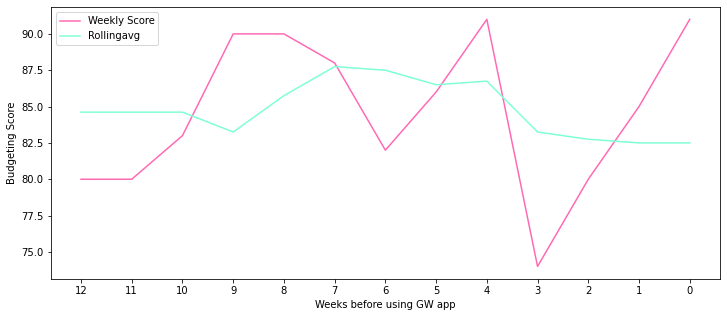

In [201]:
scores_vis.weekly_b_score(scores.weekly_score(df))